In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy import distance
from datetime import timedelta
import datetime

In [26]:
#Data Preprocessing

In [27]:
# converts a raw data file, test flag takes a small subset of the first file (the first threshold rows)
def convertToJson(inputFile, outputFile, test=False, threshold=1000):
    
    # read lines into memory
    with open(inputFile, 'r') as inFile:
        count = 0
        lines = []
        for line in inFile:
            lines.append(line)
            count +=1
            if count > threshold and test:
                break
        print(count)

    # write lines out to json file, last line needs to not have comma otherwise pandas throws error
    with open(outputFile, 'w') as outFile:
        outFile.write('[\n')
        k = len(lines)
        for i, line in enumerate(lines[:-1]):
            res = line.replace('}','},')
            outFile.write(res)
        outFile.write(lines[-1])
        outFile.write(']\n')


In [28]:
# creates a data frame given json file jsonData
def createDataFrame(jsonData):
    df = None
    with open(jsonData,'r') as data:
        df = pd.read_json(data)
    return df


In [29]:
#Driver data demo

In [30]:
fileName1 = 'rio_bq_2019000000000000'
outputFileName1 = fileName1+'.json'
df1 = convertToJson(fileName1, outputFileName1, test=True, threshold=10000)
                
fileName2 = 'rio_bq_2019000000000001'
outputFileName2 = fileName2+'.json'
df2 = convertToJson(fileName2, outputFileName2, test=True, threshold=10000)
                
df1 = createDataFrame(outputFileName1)
df2 = createDataFrame(outputFileName2)

frames = [df1, df2]
df = pd.concat(frames, ignore_index=True)

10001
10001


In [31]:
#Time data manipulation

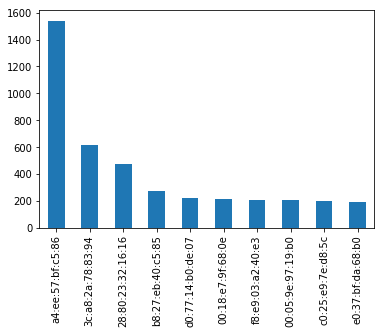

In [46]:

def convertDateTime(df):
    df1['localtime'] = pd.to_datetime(df1['localtime'])
    return df

df = convertDateTime(df)

fig, ax = plt.subplots()
top100 = df1['ClientMacAddr'].value_counts()[:10]
top100.plot.bar(ax=ax)

In [47]:
# Generate time series data for desired mac addresses

In [48]:

def createInitialAddresses(df, startTime):
    endTime = startTime + timedelta(hours=1)
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    addrCounts = df['ClientMacAddr'].value_counts()[:20].to_dict()
    return list(addrCounts.keys())

def generateMacAddrLocationTimeSeries(df, addrList,starTime , endTime):
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    macAddrLocation = dict()
    for addr in addrList:
        macAddrLocation[addr] = []
    
    for time in range(0, 160, 20):
        frameStartTime = startTime + timedelta(minutes=time)
        frameEndTime = frameStartTime + timedelta(minutes=10)
        frame = df[(df['localtime'] >= frameStartTime) & (df['localtime'] < frameEndTime)]
        for addr in macAddrLocation:
            records = frame.loc[frame['ClientMacAddr'] == addr]
            if records.empty:
                macAddrLocation[addr].append(None)
            else:
                macAddrLocation[addr].append(records.iloc[0])
    return macAddrLocation
        
# knnGroupSoloClassifier(df, addrList)

# startTime = datetime.datetime(2019,8,1,3,0,0,0, datetime.timezone.utc ) 
# endTime = datetime.datetime(2019,8,1,6,0,0,0, datetime.timezone.utc)
# addrList = createInitialAddresses(df, startTime)
# macAddrLocation = generateMacAddrLocationTimeSeries(df, addrList, startTime, endTime)
# macAddrLocation

In [49]:
# Compute distances from neighbor to neighbor

In [50]:
# macAddrLocation.keys()
type(df['localtime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [51]:
def computeNeighborDistances(df, addrList,starTime , endTime, k_neighbors=10):
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    
    addrList = set(addrList)
    neighbor_distances = dict()
    for addr in addrList:
        neighbor_distances[addr] = dict()
        
    for time in range(0, 160, 20):
        frameStartTime = startTime + timedelta(minutes=time)
        frameEndTime = frameStartTime + timedelta(minutes=2)
        frame = df[(df['localtime'] >= frameStartTime) & (df['localtime'] < frameEndTime)]
        for addr in addrList:
            addrLoc = frame.loc[frame['ClientMacAddr'] == addr][:1]
            if addrLoc.empty:
                neighbor_distances[addr][time] = None
            else:
                addrLoc = frame.loc[frame['ClientMacAddr'] == addr].iloc[0]
                coord_1 = (addrLoc['lat'],addrLoc['lng'])
                neighbors = []
                visited = set()
                visited.add(addr)
                for m,record in frame.iterrows():
                    d = distance.vincenty(coord_1, (record['lat'],record['lng']))
                    if record['ClientMacAddr'] not in visited:
                        visited.add(record['ClientMacAddr'])
                        neighbors.append((d.m, record['ClientMacAddr']))
                neighbors.sort()
                neighbor_distances[addr][time] = neighbors[:k_neighbors]


    return neighbor_distances
        
    
startTime = datetime.datetime(2019,8,1,3,0,0,0, datetime.timezone.utc ) 
endTime = datetime.datetime(2019,8,1,6,0,0,0, datetime.timezone.utc)
addrList = ['3c:a8:2a:78:83:94','a4:ee:57:bf:c5:86']

neighbor_distances = computeNeighborDistances(df, addrList, startTime, endTime)
neighbor_distances

/home/sunkam1696/inf560/ClusterChamps/env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


{'3c:a8:2a:78:83:94': {0: None,
  20: [(0.9913093402898622, 'a4:50:46:4a:0d:19'),
   (13.83656862878135, '22:07:77:76:2e:9e'),
   (18.111806015118198, '40:88:05:99:b3:36'),
   (18.54399385815268, '3c:a8:2a:78:b3:e1'),
   (20.228037923640326, 'de:14:b8:58:fa:9d'),
   (22.010413533874377, '4e:20:ac:ce:c7:1f'),
   (29.168435970336255, '38:80:df:e3:5a:45'),
   (30.36936853829875, '3c:a8:2a:78:b4:94'),
   (31.78717787125155, '38:80:df:ee:6b:1f'),
   (34.441842567925384, '38:80:df:e7:84:38')],
  40: None,
  60: [(7.419689902984126, '02:f3:96:cf:be:a6'),
   (7.487272710740744, 'dc:bf:e9:d2:f2:12'),
   (8.53603408243253, 'dc:bf:e9:ac:cc:23'),
   (9.24806610388314, 'dc:bf:e9:84:56:76'),
   (11.013034682732174, 'dc:bf:e9:1f:3f:4c'),
   (11.436148810928199, 'dc:bf:e9:94:b4:0b'),
   (14.449455721550407, 'dc:bf:e9:aa:b3:d3'),
   (16.79326224846694, 'a0:56:f3:16:a3:11'),
   (18.435197427011406, 'dc:bf:e9:31:1a:3a'),
   (19.50697290944649, 'dc:bf:e9:36:8d:ad')],
  80: [(36.83239319911344, '58:d9:c3:2

In [52]:
def classifier(neighbor_distances, max_dist_threshold=10, occurence_threshold=5):
    groups = dict()
    for addr in neighbor_distances:
        groups[addr] = []
        neighbor_count = dict()
        for time in neighbor_distances[addr]:
            if neighbor_distances[addr][time]:
                for dist, neighbor in neighbor_distances[addr][time]:
                    if dist < max_dist_threshold:
                        if neighbor in neighbor_count:
                            neighbor_count[neighbor] += 1
                        else:
                            neighbor_count[neighbor] = 1
        for neighbor in neighbor_count:
            if neighbor_count[neighbor]>occurence_threshold:
                groups[addr].append(neighbor)
        print(neighbor_count)
    return groups

groups_by_distance= classifier(neighbor_distances)


{'80:58:f8:73:83:23': 1, 'fa:58:21:11:0c:20': 1, 'b2:9d:21:32:7a:a7': 1, 'ba:92:00:31:7b:4d': 1, '86:25:75:c6:3b:f3': 1, '9e:80:1e:df:76:8b': 1, 'da:a1:19:10:42:b8': 1, 'b8:27:eb:40:c5:85': 1, '3e:03:58:24:3d:4d': 1, 'c2:d7:25:58:c9:8a': 1, '02:87:8e:dc:f3:79': 1, 'da:a1:19:29:1a:ff': 1, 'd0:77:14:b0:de:07': 1, '2e:fb:00:c9:ba:7f': 1, 'd4:63:c6:23:a3:bb': 1, 'f4:f5:24:44:9b:f2': 1, 'da:a1:19:ce:27:b4': 1, '72:bb:8d:3e:b5:8e': 1, '5e:15:2d:fc:6b:7c': 1}
{'dc:bf:e9:ac:cc:23': 1, 'c0:8c:71:fc:e0:51': 1, '58:d9:c3:86:5d:f4': 1, '58:d9:c3:d6:c4:27': 1, 'da:a1:19:fa:7d:47': 1, 'da:a1:19:87:95:11': 1, '02:f3:96:cf:be:a6': 1, 'dc:bf:e9:84:56:76': 1, 'a4:50:46:4a:0d:19': 1, 'da:a1:19:8e:23:9d': 1, 'da:a1:19:a1:5f:34': 1, '26:7e:29:de:74:f1': 1, '3c:a8:2a:78:83:91': 1, 'da:a1:19:62:6b:44': 1, '58:d9:c3:64:e0:fd': 1, 'da:a1:19:1f:ba:59': 1, 'dc:bf:e9:d2:f2:12': 1, 'da:a1:19:50:d4:eb': 1}


In [54]:
groups_by_distance

{'3c:a8:2a:78:83:94': [], 'a4:ee:57:bf:c5:86': []}